## Loading packages

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    !pip install --quiet git+https://github.com/BayraktarLab/cell2location#egg=cell2location[tutorials]

In [2]:
import os
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True' #this ensures your program will run on a GPU. 
import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


Defining where you want the results of the analysis to be

In [3]:
results_folder = './results/immune_gut_combined/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Loading Visium and reference scRNAseq data

### Visium

Load visium with scanpy, specify which out folder it can find all the visium data. 
Need to define the path in the sc.read_visium, it complains when you give the path as a separate variable.

In [4]:
adata_vis = sc.read_visium("/media/gambino/students_workdir/ibp/visium_data/Slide2-3/1345_start-EP/outs")
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0] # add sample_id to metadata. Not necessary when only using 1 sample.

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Rename genes to ENSEMBL ID: so you can match scRNAseq with visium and can ignore the non-unique name warning in the previous cell

In [5]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

You can still plot gene expression by name using standard scanpy functions as follows:

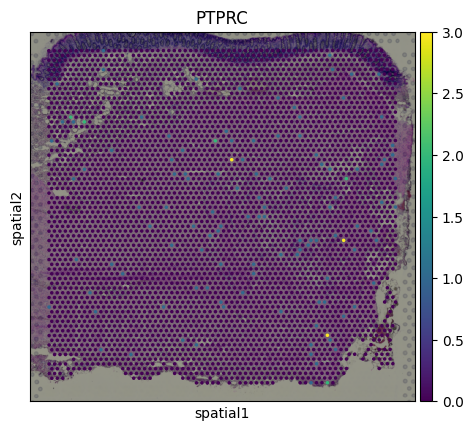

In [6]:
sc.pl.spatial(adata_vis, color='PTPRC', gene_symbols='SYMBOL')

Filter out the mitochondria-encoded genes (gene names starting with prefix mt- or MT-), as they are not relevant for cell deconvolution

In [7]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

### scRNAseq

**IMPORTANT** Ensure that the scRNAseq is **non-transformed** and **non-normalized**

paths to different scRNAdatasets:
* human gut cell atlas: 
    * '/media/gambino/students_workdir/ibp/scRNA_data/Full_obj_raw_counts_nosoupx_v2.h5ad'
* own scRNAseq dataset, celltypes annotated with:
    * low res immune cell annotation: "/media/gambino/students_workdir/ibp/celltypistannotatedimmune_combined_filtered_counts_13_11.h5"
    * human gut cell atlas annotation: "/media/gambino/students_workdir/ibp/celltypistannotatedgut_combined_filtered_counts_13_11.h5"
    * both above combined: "/media/gambino/students_workdir/ibp/celltypistannotated_combined_filtered_counts_13_11.h5" 

In [40]:
# Read data
path_to_scRNAseq = '/media/gambino/students_workdir/ibp/scRNA_data/Full_obj_raw_counts_nosoupx_v2.h5ad'
adata_gut = sc.read(path_to_scRNAseq)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [41]:
path_own_scRNADataset = "/media/gambino/students_workdir/ibp/celltypistannotatedimmune_combined_filtered_counts_13_11.h5"
adata_immune = sc.read(path_own_scRNADataset)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Rename genes to ENSEMBL ID: so can match your scRNAseq with the visium dataset and can ignore the non-unique name warning in the previous cells.

Rename `gene_ids` as necessary for your data, check `adata_ref.var` for this.

In [42]:
adata_gut.var['SYMBOL'] = adata_gut.var.index
adata_gut.var.set_index('gene_ids', drop=True, inplace=True)

adata_immune.var['SYMBOL'] = adata_immune.var.index
adata_immune.var.set_index('gene_ids', drop=True, inplace=True)

In [57]:
adata_gut

AnnData object with n_obs × n_vars = 428469 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05'
    var: 'feature_types', 'SYMBOL'

In [59]:
print(adata_gut.obs)
adata_gut.var

                                   Sample name          Diagnosis    Age  \
AAACCTGAGAACAACT-1-4918STDY7333456        T036  Pediatric healthy      4   
AAACCTGAGCGATATA-1-4918STDY7333456        T036  Pediatric healthy      4   
AAACCTGAGGAGTTTA-1-4918STDY7333456        T036  Pediatric healthy      4   
AAACCTGAGTATCTCG-1-4918STDY7333456        T036  Pediatric healthy      4   
AAACCTGAGTGACTCT-1-4918STDY7333456        T036  Pediatric healthy      4   
...                                        ...                ...    ...   
TTTGGTTTCAACACGT-1-WTDAtest7770719  A30 (398B)      Healthy adult  20-25   
TTTGGTTTCCAAATGC-1-WTDAtest7770719  A30 (398B)      Healthy adult  20-25   
TTTGGTTTCGGCGGTT-1-WTDAtest7770719  A30 (398B)      Healthy adult  20-25   
TTTGTCAGTGAAAGAG-1-WTDAtest7770719  A30 (398B)      Healthy adult  20-25   
TTTGTCATCTTGACGA-1-WTDAtest7770719  A30 (398B)      Healthy adult  20-25   

                                           sample name Region code   Fraction  \
AAACCT

,feature_types,SYMBOL
gene_ids,,
ENSG00000243485,Gene Expression,MIR1302-2HG
ENSG00000237613,Gene Expression,FAM138A
ENSG00000186092,Gene Expression,OR4F5
ENSG00000238009,Gene Expression,AL627309.1
ENSG00000239945,Gene Expression,AL627309.3
...,...,...
ENSG00000277856,Gene Expression,AC233755.2
ENSG00000275063,Gene Expression,AC233755.1
ENSG00000271254,Gene Expression,AC240274.1


In [64]:
adata_immune.obs["celltypist_cell_label_immune"].value_counts()

celltypist_cell_label_immune
Intestinal macrophages                   35685
Plasma cells                             34781
Classical monocytes                      19644
Mast cells                               12404
Tcm/Naive helper T cells                 10323
Type 1 helper T cells                     8829
DC2                                       8510
Memory B cells                            6715
Tem/Trm cytotoxic T cells                 6472
DC                                        4731
Tem/Effector helper T cells               4038
Regulatory T cells                        3381
Fibroblasts                               3125
Alveolar macrophages                      2687
Naive B cells                             2500
Germinal center B cells                   1442
ILC3                                      1436
CD16- NK cells                            1344
Proliferative germinal center B cells     1189
DC1                                       1149
CD16+ NK cells                 

In [53]:
import anndata as ad

In [54]:
adatas_test = {"Gut Atlas": adata_gut,
    "Immune": adata_immune,
}
ad.concat(adatas_test, label="dataset").obs

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


,batch,dataset
AAACCTGAGAACAACT-1-4918STDY7333456,4918STDY7333456,Gut Atlas
AAACCTGAGCGATATA-1-4918STDY7333456,4918STDY7333456,Gut Atlas
AAACCTGAGGAGTTTA-1-4918STDY7333456,4918STDY7333456,Gut Atlas
AAACCTGAGTATCTCG-1-4918STDY7333456,4918STDY7333456,Gut Atlas
AAACCTGAGTGACTCT-1-4918STDY7333456,4918STDY7333456,Gut Atlas
...,...,...
TTTGTTGGTGAATTGA-1,GC115991_SI-GA-B4,Immune
TTTGTTGGTGCCTACG-1,GC115991_SI-GA-B4,Immune
TTTGTTGGTTCAGCGC-1,GC115991_SI-GA-B4,Immune
TTTGTTGTCACCGGGT-1,GC115991_SI-GA-B4,Immune


In [56]:
print(adata_gut)
adata_immune.obs

AnnData object with n_obs × n_vars = 428469 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05'
    var: 'feature_types', 'SYMBOL'


,batch,celltypist_cell_label_immune,celltypist_conf_score_immune
AAACCCAAGCGCACAA-1,GC1004281_E2,Intestinal macrophages,0.671708
AAACCCACAAAGGCTG-1,GC1004281_E2,Alveolar macrophages,0.027584
AAACCCACATGAAGCG-1,GC1004281_E2,Fibroblasts,0.999925
AAACCCAGTCCTGAAT-1,GC1004281_E2,Tcm/Naive helper T cells,0.631702
AAACCCAGTCGTGCCA-1,GC1004281_E2,Classical monocytes,0.021004
...,...,...,...
TTTGTTGGTGAATTGA-1,GC115991_SI-GA-B4,Plasma cells,0.993543
TTTGTTGGTGCCTACG-1,GC115991_SI-GA-B4,DC2,0.260516
TTTGTTGGTTCAGCGC-1,GC115991_SI-GA-B4,Mast cells,0.999999
TTTGTTGTCACCGGGT-1,GC115991_SI-GA-B4,Plasma cells,0.999990


In [47]:
print(adata_gut.var)
adata_immune.var

                   feature_types       SYMBOL
gene_ids                                     
ENSG00000243485  Gene Expression  MIR1302-2HG
ENSG00000237613  Gene Expression      FAM138A
ENSG00000186092  Gene Expression        OR4F5
ENSG00000238009  Gene Expression   AL627309.1
ENSG00000239945  Gene Expression   AL627309.3
...                          ...          ...
ENSG00000277856  Gene Expression   AC233755.2
ENSG00000275063  Gene Expression   AC233755.1
ENSG00000271254  Gene Expression   AC240274.1
ENSG00000277475  Gene Expression   AC213203.1
ENSG00000268674  Gene Expression      FAM231C

[33538 rows x 2 columns]


,feature_types,genome,SYMBOL
gene_ids,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG
ENSG00000237613,Gene Expression,GRCh38,FAM138A
ENSG00000186092,Gene Expression,GRCh38,OR4F5
ENSG00000238009,Gene Expression,GRCh38,AL627309.1
ENSG00000239945,Gene Expression,GRCh38,AL627309.3
...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1
ENSG00000278633,Gene Expression,GRCh38,AC023491.2
ENSG00000276017,Gene Expression,GRCh38,AC007325.1


In [ ]:
adatas = []
adata.obs['dataset'] = 

for filename in existing_raw_matrices:
    adata = sc.read_10x_h5(os.path.join(DATA_DIR, filename, "outs", "filtered_feature_bc_matrix.h5"))
    adata.var_names_make_unique()
    adata.obs['batch'] = filename
    adatas.append(adata)



combined = ann.concat(adatas, merge="same")

In [20]:
adata_ref.var['SYMBOL'] = adata_ref.var.index
# rename 'gene_ids' as necessary for your data, check `adata_ref.var` for this.
adata_ref.var.set_index('gene_ids', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

## Generate Reference Cell Type Matrix

### Preprocessing before estimating reference cell type signature

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

The default parameters `cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12` are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low `cell_count_cutoff=5`, however, `cell_percentage_cutoff2` and `nonz_mean_cutoff` can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


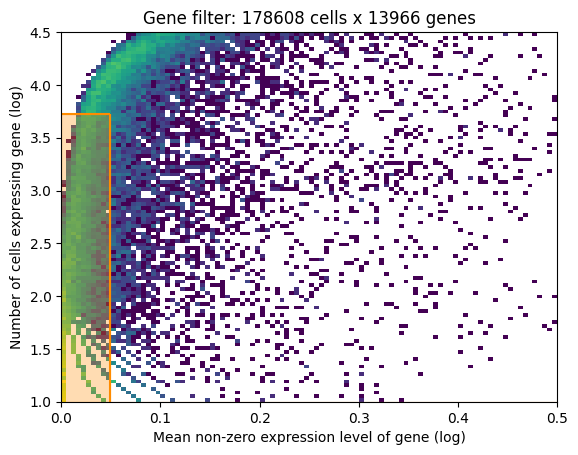

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [21]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

### Estimation of reference cell type signature (NB regression)

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

In [23]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        #batch_key='Sample', # Not necessary as we are only testing 1 sample
                        # cell type, covariate used for constructing signatures. It is called `Integrated_05` in the gut_atlas & `celltypist_cell_label_gut_immune` in own dataset
                        labels_key='celltypist_cell_label_immune',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect). Applicable if using multiple datasets
                        # categorical_covariate_keys=['Method']
                       )

In [24]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'celltypist_cell_label_immune',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 178608 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   35   │
│          n_vars          │ 13966  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                                           labels State Registry                                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃              Source Location              ┃              Categories               ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltypist_cell_label_immune'] │         Alveolar macrophages          │          0          │
│                                           │            CD16+ NK cells             │          1          │
│                                           │            CD16- NK cells             │          2          │
│                                           │          Classical monocytes          │          3          │
│                                           │                  DC                   │          4          │
│                                           │                  DC1                  │          5          │
│                                           │                  DC2                  │          6          │
│                                           │           Endothelial cells           │          7          │
│                                           │           Epithelial cells            │          8          │
│                                           │     Erythrophagocytic macrophages     │          9          │
│                                           │              Fibroblasts              │         10          │
│                                           │       Follicular helper T cells       │         11          │
│                                           │        Germinal center B cells        │         12          │
│                                           │                 ILC3                  │         13          │
│                                           │       Intermediate macrophages        │         14          │
│                                           │        Intestinal macrophages         │         15          │
│                                           │              MAIT cells               │         16          │
│                                           │              Mast cells               │         17          │
│                                           │            Memory B cells             │         18          │
│                                           │             Migratory DCs             │         19          │
│                                           │               NK cells                │         20          │
│                                           │             Naive B cells             │         21          │
│                                           │        Non-classical monocytes        │         22          │
│                                           │             Plasma cells              │         23          │
│                                           │             Plasmablasts              │         24          │
│                                           │ Proliferative germinal center B cells │         25          │
│                                           │          Regulatory T cells           │         26          │
│                                           │      Tcm/Naive cytotoxic T cells      │         27          │
│                                           │       Tcm/Naive helper T cells        │         28          │
│                                           │      Tem/Effector helper T cells      │         29          │
│                                           │      Tem/Temra cytotoxic T cells      │         30          │
│                                           │       Tem/Trm cytotoxic T cells       │         31          │
│                                           │         Type 1 helper T cells         │         32          │
│   

### Training the model to estimate cell reference types.

Note that to achieve convergence on your data you may need to increase `max_epochs=250`, check by plotting ELBO loss history during training (remove first 20 epochs from the plot). If the plot is still decreasing by the end, increase `max_epochs` 

Also note that here we are using `batch_size=2500` which is much larger than scvi-tools default and perform training on all cells in the data (`train_size=1`) - both parameters are defaults.

In [28]:
mod.train(max_epochs=250, use_gpu=True)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 250/250: 100%|██████████| 250/250 [43:00<00:00, 10.10s/it, v_num=1, elbo_train=1.03e+9]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [43:00<00:00, 10.32s/it, v_num=1, elbo_train=1.03e+9]


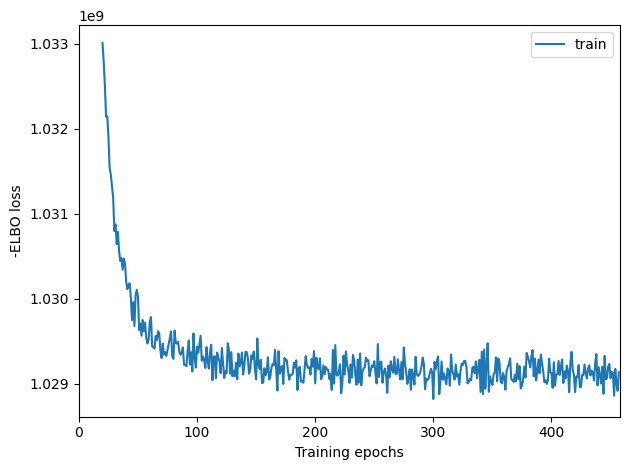

In [29]:
# ELBO plot of the history of training the model, with first 20 epochs removed
mod.plot_history(20)

#the plot that you see here now is actually from the total trained model iso the cell reference model. Need to load data again to see if the training actually converged

In [30]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 127.29it/s]


'./results/immuneOnly//reference_signatures/sc.h5ad'

### Examine QC plots

Here we simply compute the quantiles based on the samples, as we need the posterior mean and steandard deviation to make the QC plot next cell. 

If you have a large dataset, you can compute the 5%, 50% and 95% quantiles of the posterior distribution directly rather than using 1000 samples from the distribution (or any other quantiles). This speeds up application on large datasets and requires less memory - however, posterior mean and standard deviation cannot be computed this way.

In [31]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=False,
    # choose quantiles
    #add_to_varm=["means", "stds", "q05", "q95"]
    #add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': True}
)

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 135.54it/s]



* Reconstruction accuracy to assess if there are any issues with inference. This 2D histogram plot should have most observations along a noisy diagonal.
* The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. For scRNA-seq datasets which do not suffer from batch effect (this dataset does), cluster average expression can be used instead of estimating signatures with a model. When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.


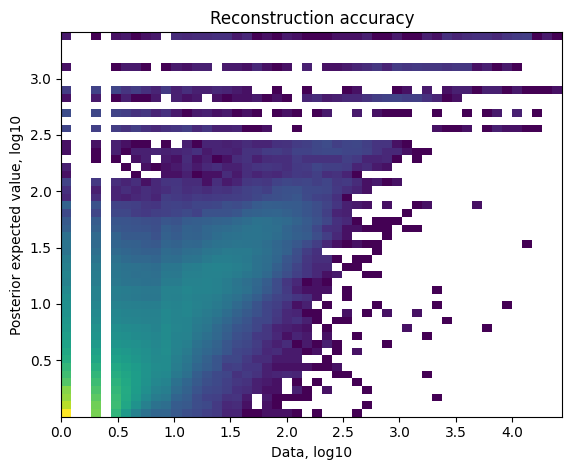

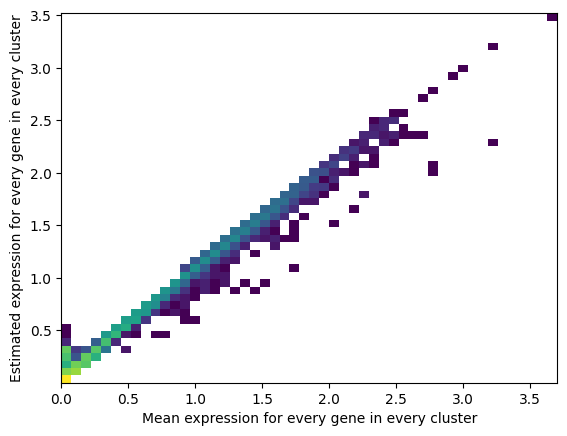

In [32]:
mod.plot_QC()

The model and output h5ad can be loaded later like this:

In [ ]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results/gutCellAtlas//reference_signatures/model.pt already downloaded                             


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/47:   2%|▏         | 1/47 [00:00<00:05,  8.81it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/47:   2%|▏         | 1/47 [00:00<00:05,  8.47it/s, v_num=1]


Extracting reference cell types signatures as a pd.DataFrame.

All parameters of the a Negative Binomial regression model are exported into reference anndata object, however for spatial mapping we just need the estimated expression of every gene in every cell type. Here we extract that from standard output:


In [33]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Alveolar macrophages,CD16+ NK cells,CD16- NK cells,Classical monocytes,DC
gene_ids,,,,,
ENSG00000237491,0.015189,0.065026,0.052533,0.054127,0.076555
ENSG00000228794,0.021545,0.037687,0.096192,0.046908,0.098398
ENSG00000187634,0.000932,0.001062,0.001825,0.001159,0.000277
ENSG00000188976,0.042757,0.158625,0.152900,0.144790,0.161742
ENSG00000272512,0.000800,0.002159,0.007339,0.010042,0.003805


## Cell2location: spatial mapping

Find shared genes and prepare anndata. Subset both anndata and reference signatures:

In [34]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)
# cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

### Choose your hyperparameters

For detailed guidance on choosing your hyperparameters and their impact, [click here](https://github.com/BayraktarLab/cell2location/blob/master/docs/images/Note_on_selecting_hyperparameters.pdf). For a short summary, continue reading:


*Choosing hyperparameter `N_cells_per_location`*
* Estimate this hyperparameter based on the paired histology images, or if not avaiable you can use images from the same tissue of unrelated experiments. If both are not avaiable, you can give an estimate based on the spatial transcriptomics technique (i.e. Visium has on average 5 cells per spot) 
* If you do estimate based on an image, you pick 10-20 random locations and manually count the nuclei to compute average cell abundance. 
* Default is a single tissue-level estimate, but can also use per-location number of cells if there are large differences between different regions on your tissue slice. 

*Choosing hyperparameter `detection_alpha`*
* Determines the amount of regularization or per-location normalisation in preprocessing. You should choose based on the amount of technical variability in RNA detection sensitivity within your slide/batch. 
* high technical variability in RNA detection sensitivity is in your sample if your observed spatial distribution of total RNA count per location doesn't match the expected cell numbers based on histological examination.
* High technical effects? Choose `detection_alpha=20` (default, as this seems common for Visium experiments on human tissues)
* Low technical effects? Choose `detection_alpha=200`. High regularization improves consistency between total estimated cell abundance per location and the nuclei count quantified in `N_cells_per_location`
* Try both settings on your data, i.e. `detection_alpha=20` and `detection_alpha=200`





In [35]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=7,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()



Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 4305  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 13953 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

### Train cell2location

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value

Epoch 30000/30000: 100%|██████████| 30000/30000 [47:48<00:00, 10.36it/s, v_num=1, elbo_train=1.69e+7]

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|██████████| 30000/30000 [47:48<00:00, 10.46it/s, v_num=1, elbo_train=1.69e+7]


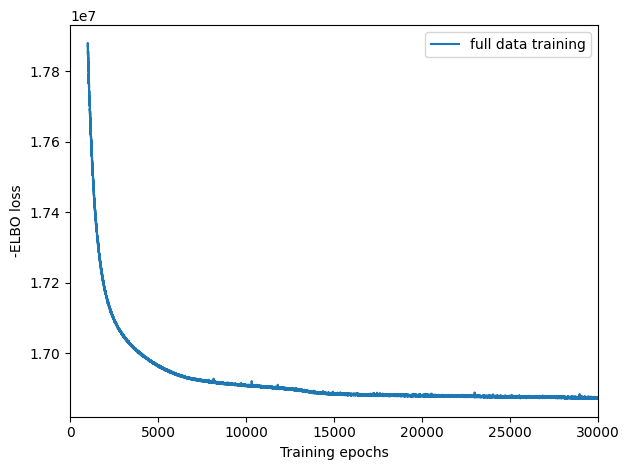

In [36]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

Exporting estimated posterior distributions of cell abundance and saving results:

In [37]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 58.54it/s]


'./results/immuneOnly//cell2location_map/sp.h5ad'

The model and output h5ad can be loaded later like this:

In [3]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

INFO     File ./results/immuneOnly//cell2location_map/model.pt already downloaded                                  


/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/abc.py:98: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device (

Epoch 1/30000:   0%|          | 1/30000 [00:00<3:37:15,  2.30it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:00<3:41:39,  2.26it/s, v_num=1]


Assessing mapping quality. Examine reconstruction accuracy to assess if there are any issues with mapping. The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.

Sampling global variables, sample: 100%|██████████| 999/999 [00:09<00:00, 104.13it/s]


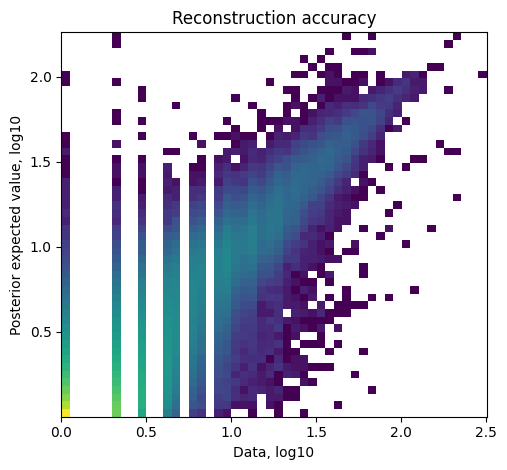

In [4]:
mod.export_posterior(adata_vis)
mod.plot_QC()

When intergrating multiple spatial batches and when working with datasets that have substantial variation of detected RNA within slides (that cannot be explained by high cellular density in the histology), it is important to assess whether cell2location normalised those effects. You expect to see similar total cell abundance across batches but distinct RNA detection sensitivity (both estimated by cell2location). You expect total cell abundance to mirror high cellular density in the histology.

TypeError: 'in <string>' requires string as left operand, not numpy.int8

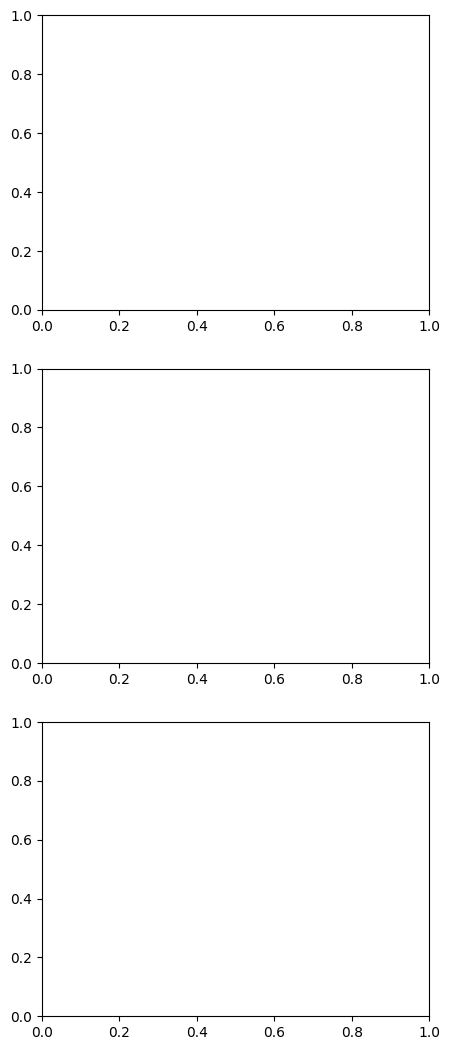

In [38]:
# Execute only if you have multiple batches.
fig = mod.plot_spatial_QC_across_batches()

## Visualising cell abundance in spatial coordinates

Note: Cell2location recommends using 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka ‘at least this amount is present’).

In [6]:
adata_vis

AnnData object with n_obs × n_vars = 4305 × 13953
    obs: 'in_tissue', 'array_row', 'array_col', '_indices', '_scvi_batch', '_scvi_labels', 'Alveolar macrophages', 'CD16+ NK cells', 'CD16- NK cells', 'Classical monocytes', 'DC', 'DC1', 'DC2', 'Endothelial cells', 'Epithelial cells', 'Erythrophagocytic macrophages', 'Fibroblasts', 'Follicular helper T cells', 'Germinal center B cells', 'ILC3', 'Intermediate macrophages', 'Intestinal macrophages', 'MAIT cells', 'Mast cells', 'Memory B cells', 'Migratory DCs', 'NK cells', 'Naive B cells', 'Non-classical monocytes', 'Plasma cells', 'Plasmablasts', 'Proliferative germinal center B cells', 'Regulatory T cells', 'Tcm/Naive cytotoxic T cells', 'Tcm/Naive helper T cells', 'Tem/Effector helper T cells', 'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells', 'Type 1 helper T cells', 'gamma-delta T cells', 'pDC'
    var: 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial'
    obsm: 'MT

In [5]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# If you have multiple batches, use the commands below to retrieve slide of interest.
# from cell2location.utils import select_slide
# slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
slide = adata_vis

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['LYVE1+ Macrophage', 'MMP9+ Inflammatory macrophage',
                         'Macrophages', 'Monocytes', 'Branch A2 (IPAN/IN)', 'Branch A3 (IPAN/IN)', 'Branch A4 (IN)', 'Branch B3 (IPAN)', 'Glia 1 (DHH+)', 'Glia 2 (ELN+)', 'Glia 3 (BCAN+)', 'Adult Glia', 'CX3CR1+ CD8 Tmem', 'cycling ENCC/glia', 'SMC (PART1/CAPN3+)', 'ICC'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )
# interesting cell names to plot for cut cell atlas    
# 'LYVE1+ Macrophage', 'MMP9+ Inflammatory macrophage', 'Macrophages', 'Monocytes', 'Branch A2 (IPAN/IN)', 'Branch A3 (IPAN/IN)', 'Branch A4 (IN)', 'Branch B3 (IPAN)', 'Glia 1 (DHH+)', 'Glia 2 (ELN+)', 'Glia 3 (BCAN+)', 'Adult Glia', 'CX3CR1+ CD8 Tmem', 'cycling ENCC/glia', 'SMC (PART1/CAPN3+)', 'ICC'],


KeyError: 'Could not find key LYVE1+ Macrophage in .var_names or .obs.columns.'

<Figure size 2136x2000 with 0 Axes>

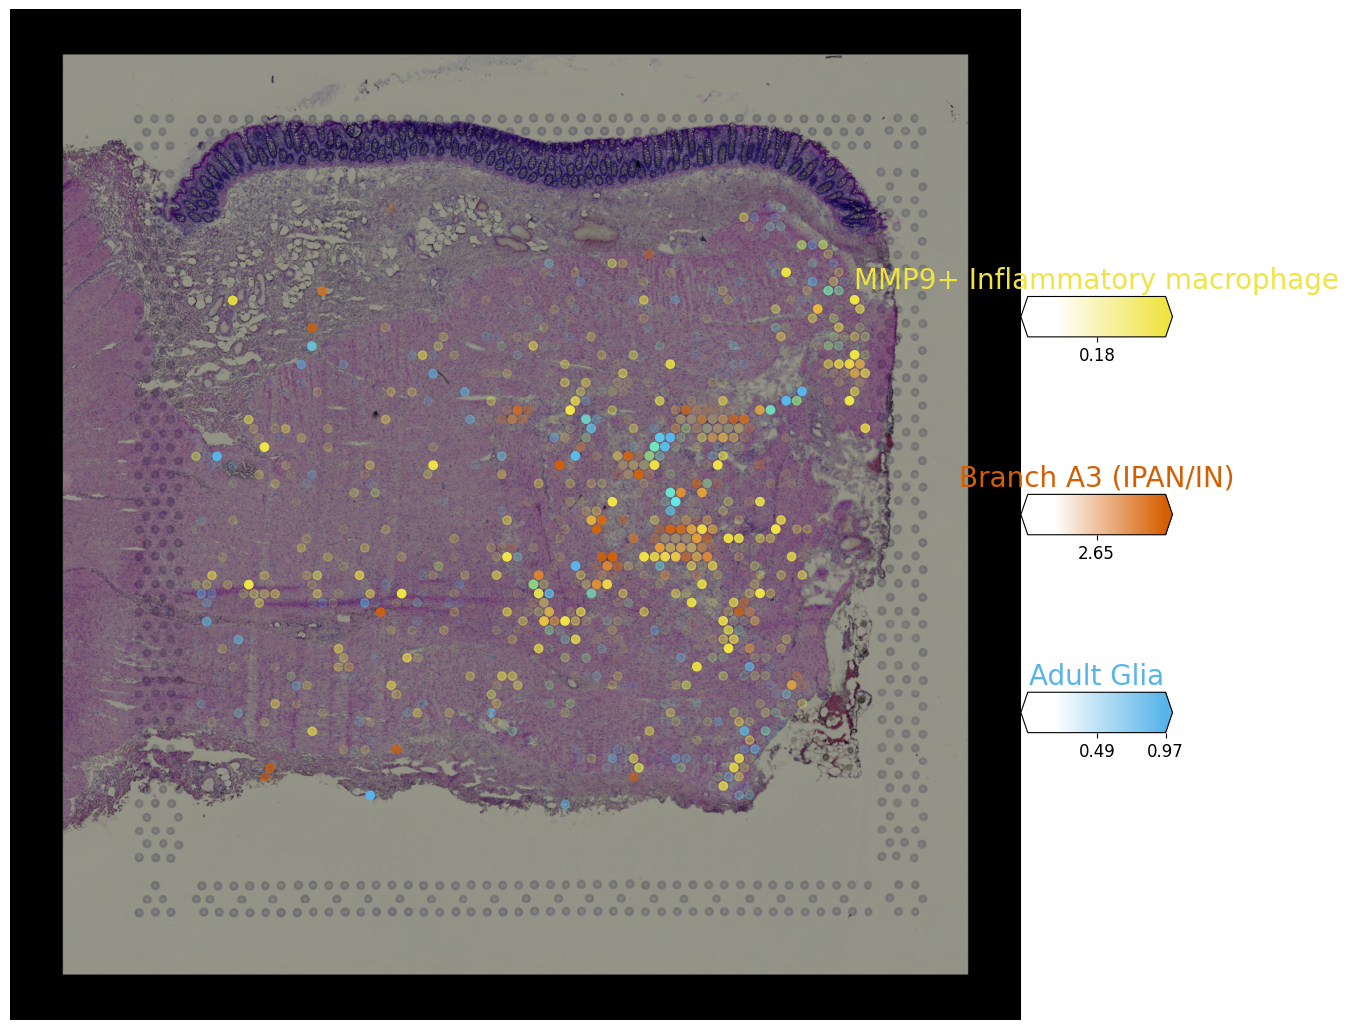

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['MMP9+ Inflammatory macrophage', 'Branch A3 (IPAN/IN)', 'Adult Glia']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

#slide = select_slide(adata_vis, 'V1_Human_Lymph_Node')
slide = adata_vis
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

## Downstream analysis - not executed for the IBP project

### Identifying discrete tissue regions by Leiden clustering

We identify tissue regions that differ in their cell composition by clustering locations using cell abundance estimated by cell2location.

We find tissue regions by clustering Visium spots using estimated cell abundance each cell type. We constuct a K-nearest neigbour (KNN) graph representing similarity of locations in estimated cell abundance and then apply Leiden clustering. The number of KNN neighbours should be adapted to size of dataset and the size of anatomically defined regions (e.i. hippocampus regions are rather small compared to size of the brain so could be masked by large `n_neighbors`). This can be done for a range KNN neighbours and Leiden clustering resolutions until a clustering matching the anatomical structure of the tissue is obtained.

The clustering is done jointly across all Visium sections / batches, hence the region identities are directly comparable. When there are strong technical effects between multiple batches (not the case here) `sc.external.pp.bbknn` can be in principle used to account for those effects during the KNN construction.

The resulting clusters are saved in `adata_vis.obs['region_cluster']`.

In [46]:
import leidenalg

In [47]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_vis, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1.1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")



/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/tools/_leiden.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(
/tmp/ipykernel_1351019/1873813358.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"].astype("category")


We can use the location composition similarity graph to build a joint integrated UMAP representation of all section/Visium batches

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


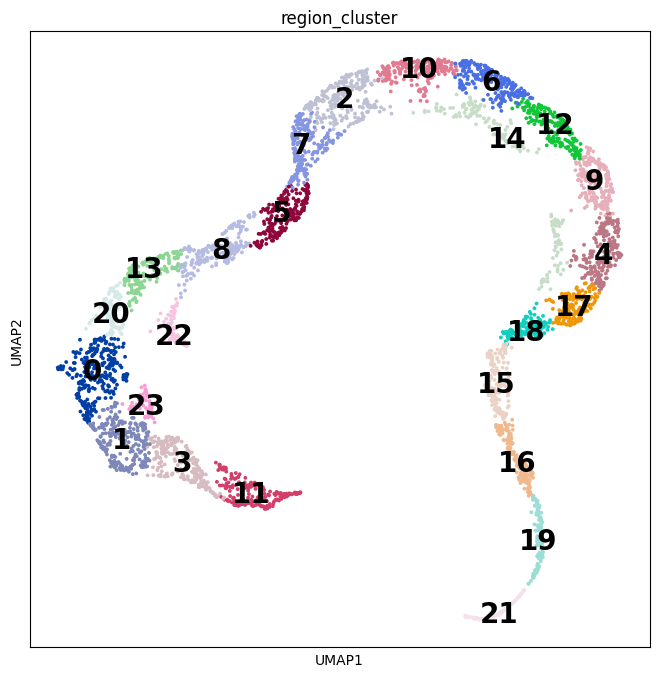

/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


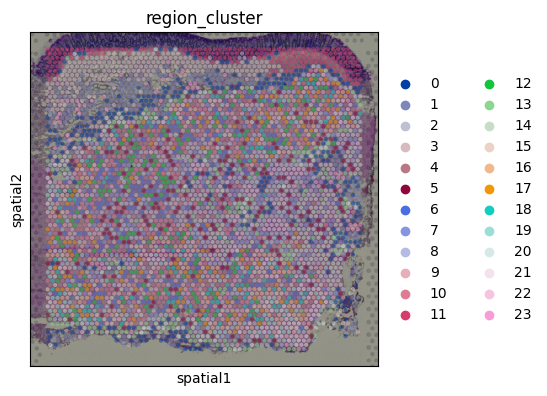

In [49]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)
    #sc.pl.umap(adata_vis, color=['sample'], size=30,
    #           color_map = 'RdPu', ncols = 2,
    #           legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_vis, color=['region_cluster'],
                  size=1.3, img_key='hires', alpha=0.5)



### Identifying cellular compartments / tissue zones using matrix factorisation (NMF)

Use non-negative matrix factorization (NMF) to capture which cell types co-localise. This decomposition naturally accounts for the fact that multiple cell types and microenvironments can co-exist at the same Visium locations, while sharing information across tissue areas (e.g. individual germinal centres)

**Tip**
* In practice, it is beetter to train NMF for a range of factors *R = 5,...,30* and select *R* as a balance between capturing fine-grained and splitting known well-established tissue zones
* If want to find a few most distinct cellular compartments, use a small number of factors. If you want to find very strong co-location signal and assume that most cell types don't co-locate, use a lot of factors (> 30 - used here)


The pipeline below automatically trains the NMF model with varying number of factors

In [48]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(11, 13), # IMPORTANT: use a wider range of the number of factors (5-30)
      #'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4305locations_134factors


/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/media/gambino/students_workdir/nynke/miniconda3/envs/cell2location/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


ValueError: The condensed distance matrix must contain only finite values.

For every factor number, the model produces the following list of folder outputs:

* `cell_type_fractions_heatmap/`: a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns)
* `cell_type_fractions_mean/`: the data used for dot plot
* `factor_markers/`: tables listing top 10 cell types most speficic to each NMF factor
* `models/`: saved NMF models
* `predictive_accuracy/`: 2D histogram plot showing how well NMF explains cell2location output
* `spatial/`: NMF weights across locatinos in spatial coordinates
* `location_factors_mean/`: the data used for the plot in spatial coordiantes
* `stability_plots/`: stability of NMF weights between training restarts

Key output that you want to examine are the files in `cell_type_fractions_heatmap/` which show a dot plot of the estimated NMF weights of cell types (rows) across NMF components (columns) which correspond to cellular compartments. Shown are relative weights, normalized across components for every cell type.

The NMF model output such as factor loadings are stored in `adata.uns[f"mod_coloc_n_fact{n_fact}"]` in a similar output format as main cell2location results in `adata.uns['mod']`.


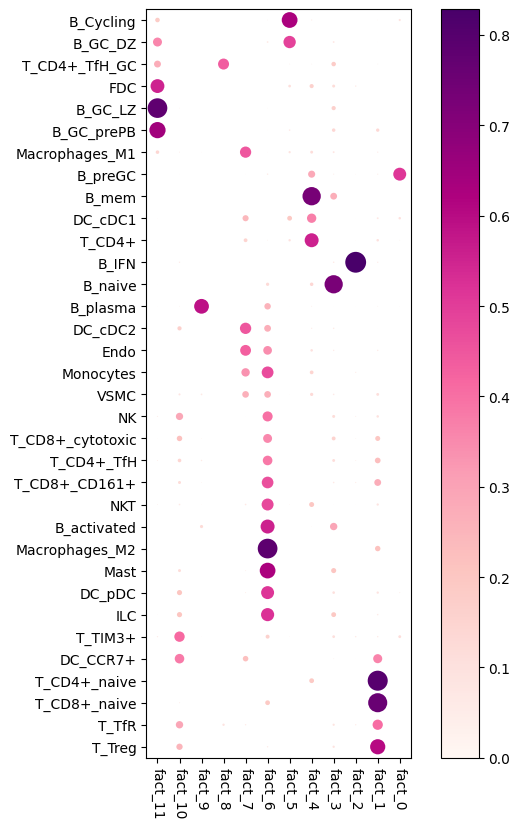

In [54]:
# Here we plot the NMF weights (Same as saved to `cell_type_fractions_heatmap`)
res_dict['n_fact12']['mod'].plot_cell_type_loadings()
